## Pix2Pix Implementation

Based on the paper: <i>Image-to-Image Translation with Conditional Adversarial Networks</i>. There is a good reference [here](https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/) and [here](https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py).

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Dense,Reshape,Dropout,BatchNormalization,Activation,UpSampling2D,Embedding
from tensorflow.keras.layers import BatchNormalization,Conv2D,LeakyReLU,Flatten,Conv2DTranspose,Concatenate
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import BinaryCrossentropy,MSE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from PIL import Image
tf.keras.backend.set_floatx('float32')

import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

In [2]:
# sketches-to-colored dataset:
x = np.load("./data/real.npy") # images already scaled
y = np.load("./data/map.npy")
print(x.shape,y.shape)

(1050, 256, 256, 3) (1050, 256, 256, 3)


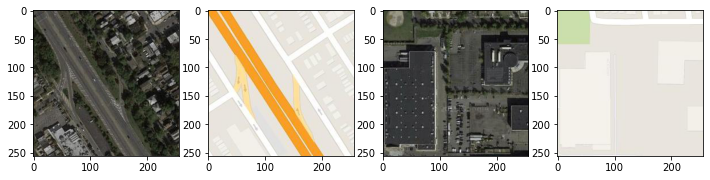

In [3]:
plt.figure(figsize=(12,3))
plt.subplot(1,4,1)
plt.imshow(((x[0]*127.5)+127.5).astype("int32"))
plt.subplot(1,4,2)
plt.imshow(((y[0]*127.5)+127.5).astype("int32"))
plt.subplot(1,4,3)
plt.imshow(((x[1]*127.5)+127.5).astype("int32"))
plt.subplot(1,4,4)
plt.imshow(((y[1]*127.5)+127.5).astype("int32"))
plt.show()

### Model Implementation

In [4]:
def enc_block(h,filter_n):
    """ downsampling block
    """
    h = Conv2D(filters=filter_n,kernel_size=4,strides=2,padding='same',activation=None)(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    return h

def dec_block(h,skip_block,filter_n,use_dropout=True):
    """ upsampling block
        -residual blocks allow for flow of low-level information
    """
    h = UpSampling2D()(h)
    h = Conv2D(filters=filter_n,kernel_size=4,strides=1,padding='same',activation=None)(h)
    h = BatchNormalization()(h)
    if use_dropout:
        h = Dropout(0.5)(h)
    h = Concatenate()([h,skip_block]) # concatenate along last dim.
    h = Activation("relu")(h)
    return h

In [5]:
def get_generator():
    """ conditional generator implementation; U-Net
        -Dropout in the place of inputted stochastic noise
    """
    source_img = Input(shape=(256,256,3))
    
    # encoding stage:
    e1 = Conv2D(filters=64,kernel_size=4,strides=2,padding='same',activation=None)(source_img)
    e1 = LeakyReLU(0.2)(e1) # 128x128
    e2 = enc_block(e1,128) # 64x64
    e3 = enc_block(e2,256) # 32x32
    e4 = enc_block(e3,512) # 16x16
    e5 = enc_block(e4,512) # 8x8
    e6 = enc_block(e5,512) # 4x4
    e7 = enc_block(e6,512) # 2x2
    
    # decoding stage:
    d1 = dec_block(e7,e6,512) # 4x4
    d2 = dec_block(d1,e5,512) # 8x8
    d3 = dec_block(d2,e4,512) # 16x16
    d4 = dec_block(d3,e3,256,use_dropout=False) # 32x32
    d5 = dec_block(d4,e2,128,use_dropout=False) # 64x64
    d6 = dec_block(d5,e1,64,use_dropout=False) # 128x128
    
    # output:
    out = UpSampling2D()(d6) # 256x256
    out = Conv2D(filters=3,kernel_size=4,strides=1,padding='same',activation=None)(out)
    out = Activation("tanh")(out)
    
    model = Model(inputs=source_img,outputs=out)
    return model

In [6]:
def get_discriminator():
    """ conditional discriminator implementation
        -PatchGAN with linear output
    """
    source_img = Input(shape=(256,256,3)) # img to be conditioned on
    target_img = Input(shape=(256,256,3)) # determining if target image is real or fake
    merged_img = Concatenate()([source_img,target_img]) # concatenate along last dim.
    
    h = Conv2D(64,kernel_size=4,strides=2,padding='same')(merged_img)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(128,kernel_size=4,strides=2,padding='same')(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(256,kernel_size=4,strides=2,padding='same')(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(512,kernel_size=4,strides=2,padding='same')(h)
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(512,kernel_size=4,strides=1,padding='same')(h) # 16x16
    h = BatchNormalization()(h)
    h = LeakyReLU(0.2)(h)
    h = Conv2D(1,kernel_size=4,strides=1,padding='same')(h) # linear output
    h = Activation("sigmoid")(h)
    
    model = Model(inputs=[source_img,target_img],outputs=h)
    return model

In [7]:
def discriminator_loss(y_true,y_pred):
    """ custom discriminator loss
    """
    y_pred = Flatten()(y_pred) # Nx256
    disc_loss = BinaryCrossentropy()(y_true,y_pred)
    #disc_loss = tf.reduce_mean(MSE(y_true,y_pred)) # when using linear output
    return disc_loss

In [8]:
def discriminator_model(discriminator,optimizer):
    """ compiling discriminator model
    """
    source_img = Input(shape=(256,256,3))
    target_img = Input(shape=(256,256,3))
    out = discriminator([source_img,target_img])
    
    model = Model(inputs=[source_img,target_img],outputs=out)
    model.compile(loss=discriminator_loss,loss_weights=[0.5],optimizer=optimizer)
    return model

In [9]:
def adversarial_model(generator,discriminator,optimizer,l1_lam=100):
    """ compiling adversarial model - used to train generator
    """
    source_img = Input(shape=(256,256,3)) # img to be conditioned on
    gen = generator(source_img)
    out = discriminator([source_img,gen])
    
    model = Model(inputs=source_img,outputs=[out,gen])
    model.compile(loss=[discriminator_loss,'mean_absolute_error'],loss_weights=[1,l1_lam],optimizer=optimizer)
    return model

In [10]:
d = get_discriminator()
generator = get_generator()
discriminator = discriminator_model(d,optimizer=Adam(lr=0.0002,beta_1=0.5))
adversarial = adversarial_model(generator,d,optimizer=Adam(lr=0.0002,beta_1=0.5))

### Model Training

The noise prior z~N(0,1)

In [ ]:
num_epochs=100
batch_size=50

for epoch_i in range(num_epochs): # number of epochs
    all_a_losses = []
    all_d_losses = []
    print("Epoch {}:".format(epoch_i+1))
    
    for i in range(0,len(x)-batch_size,batch_size):
        x_subset = x[i:i+batch_size] # source images
        y_subset = y[i:i+batch_size] # target images
        
        # training the discriminator:
        x_gen = generator(x_subset[:int(batch_size/2)]) # generator(x_subset)
        disc_source_x = np.vstack((x_subset[:int(batch_size/2)],x_subset[:int(batch_size/2)])) # np.vstack((x_subset,x_subset))
        disc_target_x = np.vstack((y_subset[:int(batch_size/2)],x_gen)) #np.vstack((y_subset,x_gen))
        disc_y = np.vstack([np.ones((int(batch_size/2),256)),np.zeros((int(batch_size/2),256))]).astype("float32") #np.vstack([np.ones((batch_size,256)),np.zeros((batch_size,256))]).astype("float32")
        discriminator.trainable=True
        d_loss = discriminator.train_on_batch([disc_source_x,disc_target_x],disc_y)
        all_d_losses.append(float(d_loss))
        
        # training the generator:
        adv_y = np.ones([batch_size,256]).astype("float32") # switch labels to maximize the domain-confusion
        discriminator.trainable=False
        a_loss = adversarial.train_on_batch(x_subset,[adv_y,y_subset])
        all_a_losses.append(float(a_loss[0]))
        
        if i%250 == 0:
            plt.figure(figsize=(15,4))
            for j in range(4):
                gen = ((generator(np.expand_dims(x_subset[j],axis=0)).numpy()*127.5)+127.5).astype("int32")[0]
                act = ((y_subset[j]*127.5)+127.5).astype("int32")
                plt.subplot(1,8,j*2+1)
                plt.imshow(act)
                plt.subplot(1,8,j*2+2)
                plt.imshow(gen)
            plt.show()
            for j in range(4):
                ain = ((x_subset[j]*127.5)+127.5).astype("int32")
                plt.subplot(1,4,j+1)
                plt.imshow(ain)
            plt.show()
            
    print("gen. loss:{}; disc. loss:{}".format(sum(all_a_losses)/len(all_a_losses),sum(all_d_losses)/len(all_d_losses)))            
    print("--------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------")

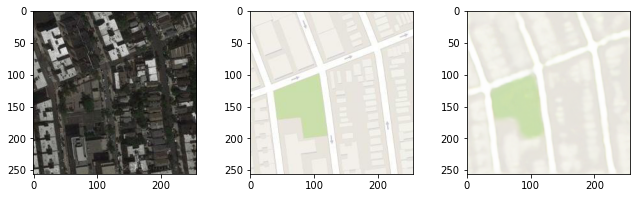

In [19]:
j=302
gen = ((generator(np.expand_dims(x[j],axis=0)).numpy()*127.5)+127.5).astype("int32")[0]
act = ((y[j]*127.5)+127.5).astype("int32")
xin = ((x[j]*127.5)+127.5).astype("int32")
plt.figure(figsize=(11,3))
plt.subplot(1,3,1)
plt.imshow(xin)
plt.subplot(1,3,2)
plt.imshow(act)
plt.subplot(1,3,3)
plt.imshow(gen)
plt.show()

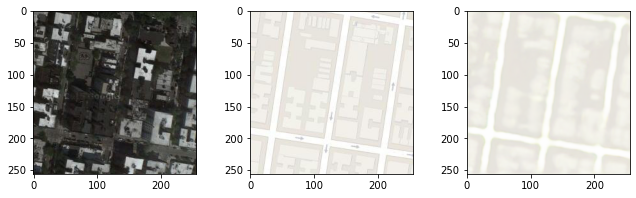

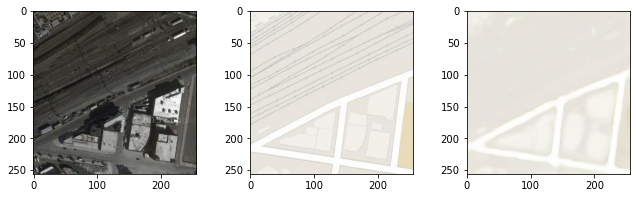

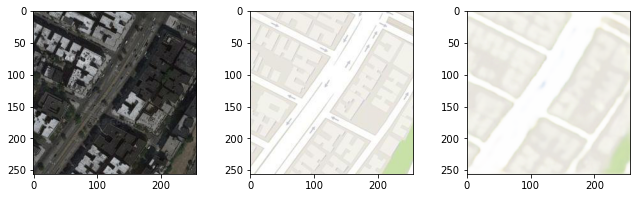

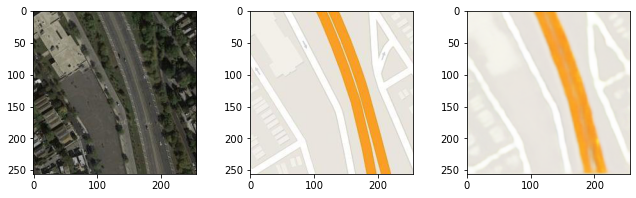

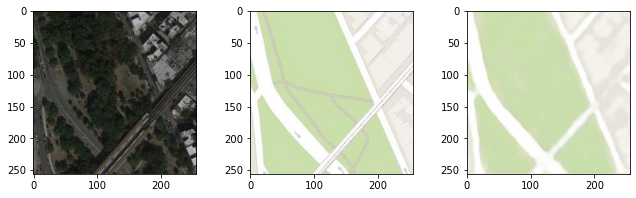